In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import sklearn
import pandas as pd
import scipy.stats as stats

#from keras import Sequential
#from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasRegressor

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression



In [2]:
neuron_data = {}

files = sorted(os.listdir('../neuron_logs/train_data'))

In [3]:
def reduce_to_statistics(activations, labels, debug=False):
    sorted_data = []
    for i in range(10): #hardcoded MOFO
        sorted_data += [[]]
    for i, a in zip(labels, activations):
        sorted_data[i] += [a]
    if debug:
        return(sorted_data)
    statistics = []
    for ar in sorted_data:
        curr_stats = stats.describe(ar)
        statistics += [curr_stats.mean, curr_stats.variance, curr_stats.skewness, curr_stats.kurtosis, curr_stats.minmax[0],
                       curr_stats.minmax[1], curr_stats.nobs]
        #print(statistics)
    return(statistics)

In [30]:
features, labels = [], []
target = 'usefulness_loss'
fin = 10
activations_no = 2000
for i, filename in enumerate(files[:]):
    with open(os.path.join('..', 'neuron_logs', 'train_data', filename), 'r') as f:
        print(filename)
        neuron_data = json.load(f)
    if i == 10:
        break
    for e in neuron_data.keys():
        if e == '0' or int(e) > fin:
            #print(e)
            continue
        for neuron in neuron_data[e]:
            if ' ' not in neuron:
                continue
            current_data = neuron_data[e][neuron]
            important_features = []
            important_features = current_data['activations'][:activations_no]
            important_features += reduce_to_statistics(current_data['activations'], neuron_data[e]['original_labels'])
            important_features += [current_data['depth']]
            important_features += [current_data['inverse_depth']]
            important_features += [current_data['width']]
            # important_features += [current_data['input_weights']]
            # important_features += [current_data['output_weights']]
            important_features += [current_data['reg_loss_in_layer']]
            important_features += [e]
            features += [important_features]
            #labels += [current_data[target]]
            labels += [current_data[target]]

output_20191013-181903.json
output_20191015-203714.json
output_20191015-215448.json
output_20191015-231129.json
output_20191016-002746.json
output_20191016-014510.json
output_20191016-030245.json
output_20191016-042123.json
output_20191016-053821.json
output_20191016-065412.json
output_20191016-081229.json


In [31]:
features = np.array(features)
labels = np.array(labels)
print(features.shape, labels.shape)

(12000, 2075) (12000,)


In [32]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [55]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

testscaler = StandardScaler()
scaler.fit(X_test)
X_test = scaler.transform(X_test)

In [34]:
print(f"{X_train.shape} {X_test.shape} {y_train.shape} {y_test.shape}")
reg = linear_model.LinearRegression(n_jobs = -1)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_pred, y_test)

(9600, 2075) (2400, 2075) (9600,) (2400,)


0.015134441803094187

In [35]:
reg = linear_model.Ridge(alpha = 0.5)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_pred, y_test)

0.013476282373987472

In [37]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_pred, y_test)

0.03967746659205583

In [38]:
reg = linear_model.LassoCV(cv=5, random_state=0)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_pred, y_test)

0.016504572996347316

In [57]:
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_pred, y_test)

0.013474866678859278

In [43]:
from sklearn.datasets import make_classification
from torch import nn
import torch
import torch.nn.functional as F
import torch.optim as optim


import skorch
from skorch import NeuralNetClassifier
from skorch import NeuralNetRegressor

In [50]:
class RegressorModule(nn.Module):
    def __init__(
            self,
            num_units=1000,
            nonlin=F.relu,
            dropout=0.5,
    ):
        super(RegressorModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin
        self.dropout = dropout

        self.dense0 = nn.Linear(X_train.shape[1], num_units)
        self.nonlin = nonlin
        self.dropout1 = nn.Dropout(dropout)
        self.dense1 = nn.Linear(num_units, num_units)
        self.dropout2 = nn.Dropout(dropout)
        self.denselast = nn.Linear(num_units, 50)
        self.output = nn.Linear(50, 1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout1(X)
        X = F.relu(self.dense1(X))
        X = self.dropout2(X)
        X = F.relu(self.denselast(X))
        X = self.output(X)
        return X

In [51]:
from skorch.callbacks import LRScheduler

lrscheduler = LRScheduler(monitor='train_loss',
            policy='ReduceLROnPlateau', # step_size=15, gamma=0.5)
            mode='min', factor=0.2, patience=10, verbose=True, 
            threshold=0.00001, threshold_mode='rel', 
            cooldown=0, min_lr=0, eps=1e-08)

from skorch.callbacks import Checkpoint

checkpoint = Checkpoint(
    f_params='best_model.pt', monitor='valid_loss_best')

from skorch.callbacks import EarlyStopping

earlystopping = EarlyStopping(
    monitor='train_loss',
    patience=20,
    threshold=0.0001,
    threshold_mode='abs',
    lower_is_better=True,)

In [52]:
net = NeuralNetRegressor(
    RegressorModule,
    max_epochs=200,
    lr=0.1,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    # callbacks=[skorch.callbacks.LRScheduler(skorch.callbacks.WarmRestartLR)],
    callbacks = [lrscheduler, checkpoint, earlystopping],
    warm_start=False
)

In [56]:
net.fit(X_train, y_train.reshape(-1, 1))

Re-initializing module.
Re-initializing optimizer because the following parameters were re-set: momentum.
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.1365        0.0523     +  3.3188
      2        0.0860        0.0803        3.1918
      3        0.0466        0.0514     +  3.3489
      4        0.0442        0.0516        3.5505
      5        0.0441        0.0516        3.3122
      6        0.0442        0.0516        3.3164
      7        0.0441        0.0516        3.4998
      8        0.0441        0.0516        3.1677
      9        0.0441        0.0516        3.2119
     10        0.0441        0.0516        3.3725
     11        0.0441        0.0516        3.6719
     12        0.0441        0.0516        3.3239
     13        0.0441        0.0516        3.1727
     14        0.0441        0.0516        4.5714
     15        0.0441        0.0516        4.4413
     16        0.0441        0.0516        3

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=RegressorModule(
    (dense0): Linear(in_features=2075, out_features=1000, bias=True)
    (dropout1): Dropout(p=0.5, inplace=False)
    (dense1): Linear(in_features=1000, out_features=1000, bias=True)
    (dropout2): Dropout(p=0.5, inplace=False)
    (denselast): Linear(in_features=1000, out_features=50, bias=True)
    (output): Linear(in_features=50, out_features=1, bias=True)
  ),
)

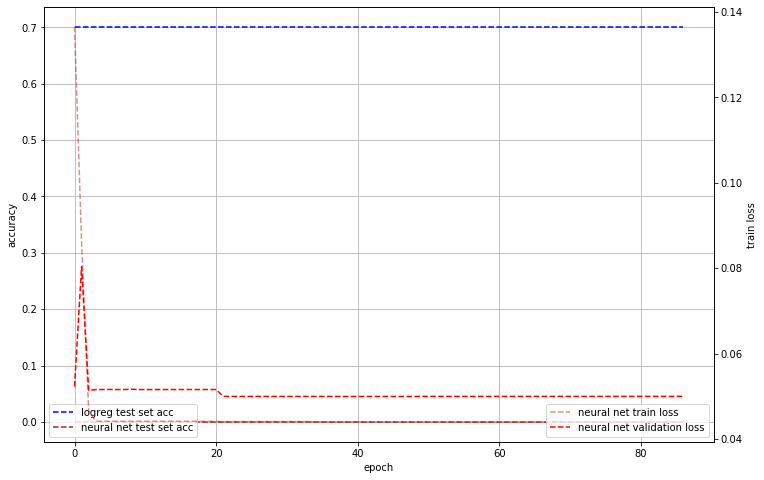

In [61]:
#valid_acc = [x['valid_acc'] for x in net.history]
train_loss = [x['train_loss'] for x in net.history]
valid_loss = [x['valid_loss'] for x in net.history]
fig, ax1 = plt.subplots(figsize = (12, 8), facecolor = 'w')

# ax1.plot(range(len(valid_acc)), valid_acc, color='firebrick', label = 'neural net validation acc')


ax1.plot(range(len(valid_loss)), [reg.score(X_test, y_test)]*len(valid_loss),  '--', color = 'blue', label = 'logreg test set acc')
ax1.plot(range(len(valid_loss)), [net.score(X_test, y_test)]*len(valid_loss), '--', color = 'firebrick', label = 'neural net test set acc')


ax2 = ax1.twinx()
ax2.plot(range(len(valid_loss)), train_loss, '--', alpha = 0.5, color='firebrick', label = 'neural net train loss')
ax2.plot(range(len(valid_loss)), valid_loss, '--', color='red', label = 'neural net validation loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax2.set_ylabel('train loss')
ax1.grid(True)
ax1.legend(loc = 3)
ax2.legend(loc = 4)